In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time

In [2]:
df = pd.read_csv("../data/MSFT_complete.csv", parse_dates = True, index_col = 'Date')
del df['Unnamed: 0']
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-09-21,25.110001,25.370001,25.100000,25.299999,19.717058,28878700
2009-09-22,25.400000,25.820000,25.290001,25.770000,20.083347,61376700
2009-09-23,25.920000,26.250000,25.639999,25.709999,20.036585,60599900
2009-09-24,25.920000,26.110001,25.660000,25.940001,20.215834,56302900
2009-09-25,25.690001,25.820000,25.520000,25.549999,19.911896,50158900
...,...,...,...,...,...,...
2020-05-24,183.190002,184.460007,182.539993,183.509995,183.509995,20826900
2020-05-25,183.190002,184.460007,182.539993,183.509995,183.509995,20826900
2020-05-26,186.339996,186.500000,181.100006,181.570007,181.570007,36073600


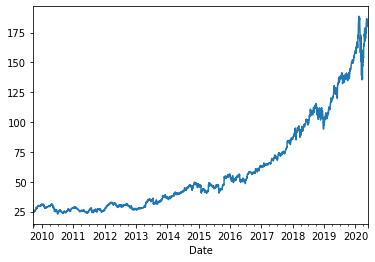

In [3]:
df['Close'].plot()

In [4]:
df.corr()['Close']

Open         0.999668
High         0.999806
Low          0.999784
Close        1.000000
Adj Close    0.999920
Volume      -0.324246
Name: Close, dtype: float64

In [5]:
df.drop(columns=['Volume','Adj Close'],inplace=True)

In [59]:
df.columns = [['open', 'high', 'low','close',]]
df

,open,high,low,close
Date,,,,
2009-09-21,25.110001,25.370001,25.100000,25.299999
2009-09-22,25.400000,25.820000,25.290001,25.770000
2009-09-23,25.920000,26.250000,25.639999,25.709999
2009-09-24,25.920000,26.110001,25.660000,25.940001
2009-09-25,25.690001,25.820000,25.520000,25.549999
...,...,...,...,...
2020-05-24,183.190002,184.460007,182.539993,183.509995
2020-05-25,183.190002,184.460007,182.539993,183.509995
2020-05-26,186.339996,186.500000,181.100006,181.570007


In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [8]:
data = sc.fit_transform(df)

In [61]:
data

array([[0.01205539, 0.01224759, 0.01447417, 0.01382099],
       [0.01378611, 0.01493607, 0.01563455, 0.01665761],
       [0.01688947, 0.01750508, 0.01777207, 0.01629549],
       ...,
       [0.97427788, 0.97490741, 0.96720413, 0.95696789],
       [0.9376343 , 0.94796277, 0.93972154, 0.95841632],
       [0.94085707, 0.96086747, 0.96280691, 0.9559418 ]])

In [10]:
train_ind = int(0.6*len(df))
val_ind = train_ind + int(0.2*len(df))

In [11]:
train = data[:train_ind]
val = data[train_ind:val_ind]
test = data[val_ind:]

In [12]:
train.shape, test.shape, val.shape

((2341, 4), (782, 4), (780, 4))

In [13]:
xtrain,ytrain,xval,yval,xtest,ytest = train[:,:4],train[:,3],val[:,:4],val[:,3],test[:,:4],test[:,3]
xtrain.shape, ytrain.shape, 

((2341, 4), (2341,))

In [14]:
lookback = 60
n_features = 4
output_dim = 4
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

In [15]:
x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (2281, 60, 4)
y_train (2281,)


In [16]:
x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_test (722, 60, 4)
y_test (722,)


In [17]:
x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)


x_val (720, 60, 4)
y_val (720,)


In [18]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [50]:
model = Sequential() 
model.add(LSTM(120,input_shape = (lookback, n_features), return_sequences=True))
model.add(LSTM(105))
model.add(Dense(1))

In [51]:
model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

In [52]:
start = time()
print("start:",0)
model.fit(x_train,y_train, epochs = 50, batch_size=30, 
          validation_data=(x_val,y_val),verbose = 1, 
          shuffle = False, callbacks=[earlystop])
print("end:",time()-start)

start: 0
Train on 2281 samples, validate on 720 samples
Epoch 1/50
2281/2281 [==============================] - 6s 3ms/step - loss: 2.4981e-04 - val_loss: 6.8158e-04
Epoch 2/50
2281/2281 [==============================] - 7s 3ms/step - loss: 2.2215e-04 - val_loss: 0.0015
Epoch 3/50
2281/2281 [==============================] - 5s 2ms/step - loss: 3.4510e-04 - val_loss: 0.0027
Epoch 4/50
2281/2281 [==============================] - 6s 3ms/step - loss: 4.4322e-04 - val_loss: 0.0056
Epoch 5/50
2281/2281 [==============================] - 9s 4ms/step - loss: 4.6592e-04 - val_loss: 0.0065
Epoch 6/50
2281/2281 [==============================] - 5s 2ms/step - loss: 5.9143e-04 - val_loss: 0.0086
Epoch 7/50
2281/2281 [==============================] - 5s 2ms/step - loss: 5.4063e-04 - val_loss: 0.0097
Epoch 8/50
2281/2281 [==============================] - 8s 3ms/step - loss: 6.5926e-04 - val_loss: 0.0062
Epoch 9/50
2281/2281 [==============================] - 6s 3ms/step - loss: 0.0011 - val_los

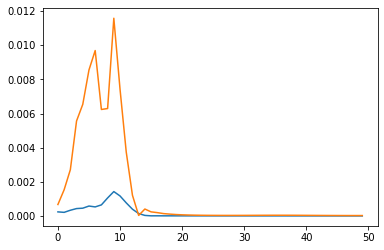

In [53]:
loss = model.history.history
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])

In [54]:
y_pred = model.predict(x_test)

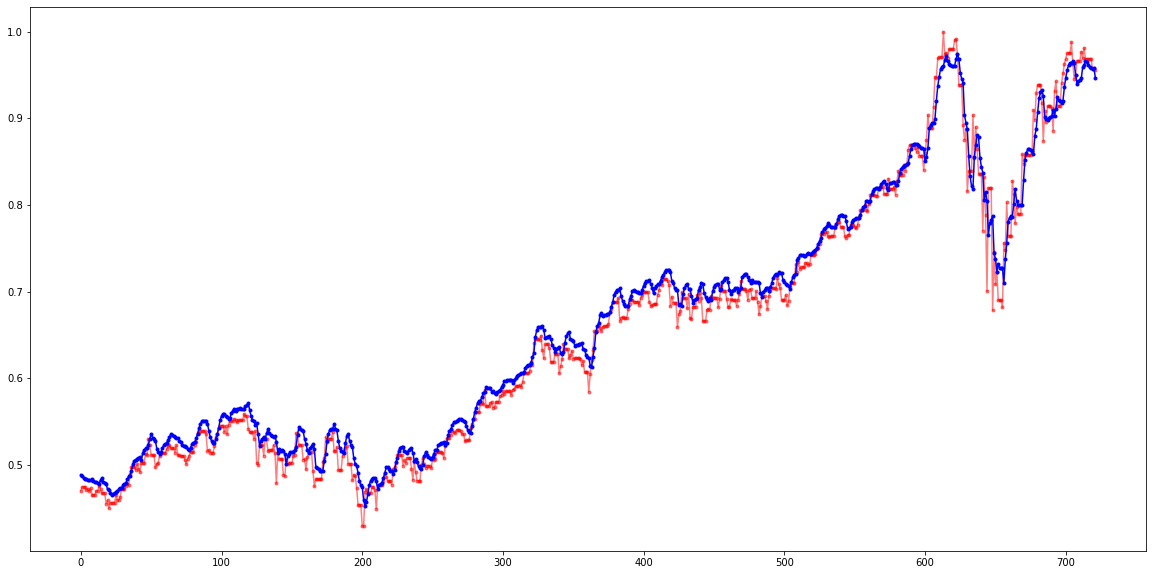

In [55]:

plt.figure(figsize=(20,10))
plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)

In [56]:
model.save("Testing_Hyper_paramters_11.h5")

In [57]:
from numpy import savetxt

In [58]:
savetxt('xtest.csv', x_test, delimiter=',')

ValueError: Expected 1D or 2D array, got 3D array instead